https://github.com/LabForComputationalVision/universal_inverse_problem

Colab version of:
https://github.com/LabForComputationalVision/universal_inverse_problem/blob/master/Demo.ipynb

In [1]:
# Instalar el github
!git clone "https://github.com/LabForComputationalVision/universal_inverse_problem.git"


fatal: destination path 'universal_inverse_problem' already exists and is not an empty directory.


In [2]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'universal_inverse_problem/code')
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *


os.chdir('universal_inverse_problem')

%matplotlib inline

In [3]:
os.getcwd()

'/content/universal_inverse_problem'

1. Denoiser architecture

In [4]:
# Print a list of pre-trained denoiser architectures
print( os.listdir('denoisers'))

# Choose an architecture from the list
architecture = 'BF_CNN'

['BF_CNN']


2. Training dataset

In [5]:
# Print a list of training datasets associated with the architecture
print(os.listdir(os.path.join('denoisers',architecture)))

# Choose a trainig set:
training_data = 'BSD300_color'

if 'color' in training_data.split('_'):
    grayscale = False # number of input and output channels is 3
    C = 3
else:
    grayscale = True # number of input and output channels is 1
    C = 1

['BSD300_color', 'mnist_gray', 'BSD400_gray']


In [6]:
# Now, choose the range of noise used during training from the list below
print(os.listdir(os.path.join('denoisers',architecture,training_data)))

training_noise='noise_range_0to100'

['noise_range_0to100']


In [7]:
denoiser = load_denoiser(architecture=architecture,
                         grayscale=grayscale,
                         training_data=training_data,
                         training_noise=training_noise)

denoiser.eval();

# Image synthesis



In [14]:
# LEER IMAGEN DE UN URL
from PIL import Image

import requests

url = "https://www.uv.es/lapeva/Valero_2001.jpg"
im = Image.open(requests.get(url, stream=True).raw)

XX = im.resize([40,40],2)

x = np.asarray(XX)/255
print(x.shape)

x = torch.tensor(x).permute(2,0,1) #np.transpose(x,[2,0,1])
x = x.float()
print(x.shape)

(40, 40, 3)
torch.Size([3, 40, 40])


In [15]:
import numpy as np
import torch
import time
import os



### Takes a tensor of size (n_ch, im_d1, im_d2)
### and returns a tensor of size (n_ch, im_d1, im_d2)
def univ_inv_sol_val(model, x, x_c ,task ,sig_0=1, sig_L=.01, h0=.01 , beta=.01 , freq=5):
    '''
    @x_c:  M^T.x)
    @task: the specific linear inverse problem
    @sig_0: initial sigma (largest)
    @sig_L: final sigma (smallest)
    @h0: 1st step size
    @beta:controls added noise in each iteration (0,1]. if 1, no noise is added. As it decreases more noise added.
    '''

    M_T = task.M_T #low rank measurement matrix - in function form
    M = task.M #inverse of M_T

    n_ch, im_d1,im_d2 = M(x_c).size()
    N = n_ch* im_d1*im_d2
    intermed_Ys=[]

    # initialize y
    e =  torch.ones_like(M(x_c), requires_grad= False )
    #y = torch.normal((e - M(M_T(e)))*.5 + M(x_c), sig_0)
    y = x
    y = y.unsqueeze(0)
    y.requires_grad = False

    if freq > 0:
        intermed_Ys.append(y.squeeze(0))


    if torch.cuda.is_available():
        y = y.cuda()

    f_y = model(y)


    sigma = torch.norm(f_y)/np.sqrt(N)


    t=1
    start_time_total = time.time()
    while sigma > sig_L:


        h = h0*t/(1+ (h0*(t-1)) )
        with torch.no_grad():
            f_y = model(y)

        d = f_y - M(M_T(f_y[0])) + ( M(M_T(y[0]))  - M(x_c) )


        sigma = torch.norm(d)/np.sqrt(N)

        gamma = sigma*np.sqrt(((1 - (beta*h))**2 - (1-h)**2 ))

        noise = torch.randn(n_ch, im_d1,im_d2)

        if torch.cuda.is_available():
            noise = noise.cuda()

        y = y -  h*d + gamma*noise

        if freq > 0 and t%freq== 0:
            print('-----------------------------', t)
            print('sigma ' , sigma.item() )
            intermed_Ys.append(y.squeeze(0))


        t +=1


    print("-------- total number of iterations, " , t )
    print("-------- average time per iteration (s), " , np.round((time.time() - start_time_total)/(t-1)  ,4) )

    denoised_y = y - model(y)


    return denoised_y.squeeze(0), intermed_Ys




----------------------------- 5
sigma  0.05001608654856682
----------------------------- 10
sigma  0.05013570934534073
----------------------------- 15
sigma  0.04408149793744087
----------------------------- 20
sigma  0.03487108647823334
----------------------------- 25
sigma  0.024563120678067207
----------------------------- 30
sigma  0.01604841649532318
----------------------------- 35
sigma  0.010431302711367607
-------- total number of iterations,  37
-------- average time per iteration (s),  0.0791
value range -0.33 0.46


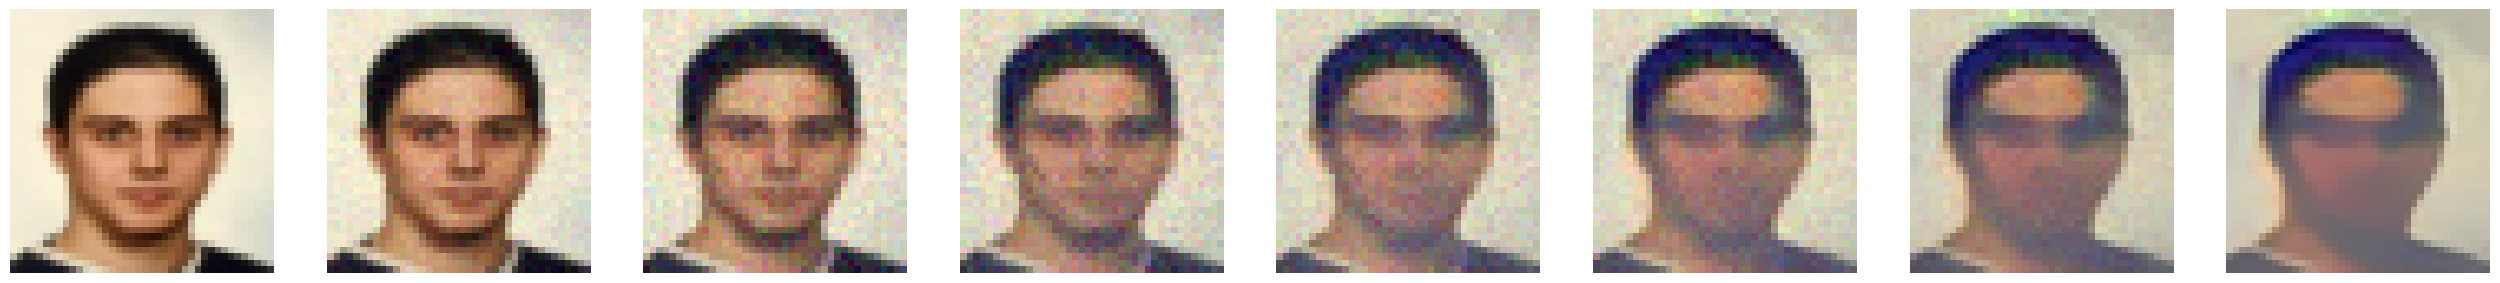

In [19]:
# choose the size of the sample patch:
patch_size = (C,40,40) #choose 28x28 for mnist patch size
x_c = torch.zeros(patch_size)
if torch.cuda.is_available():
    x = x.cuda()

synth = synthesis()
sample, interm_Ys = univ_inv_sol_val(denoiser,
                                 x = x-0.5,
                                 x_c = x_c,
                                 task = synth,
                                 sig_0 = 5,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = 0.5,  # change beta to see how quality of generated samples change
                                 freq = 5)

## plot the progression and the final sample
plot_synthesis(interm_Ys, sample)

----------------------------- 5
sigma  0.13858959078788757
----------------------------- 10
sigma  0.12022563070058823
----------------------------- 15
sigma  0.08769477903842926
----------------------------- 20
sigma  0.059461306780576706
----------------------------- 25
sigma  0.04080062732100487
----------------------------- 30
sigma  0.02910607121884823
----------------------------- 35
sigma  0.021442806348204613
----------------------------- 40
sigma  0.0165092870593071
----------------------------- 45
sigma  0.013207484036684036
----------------------------- 50
sigma  0.011109542101621628
----------------------------- 55
sigma  0.009979884140193462
-------- total number of iterations,  56
-------- average time per iteration (s),  0.0842
value range -0.33 0.46


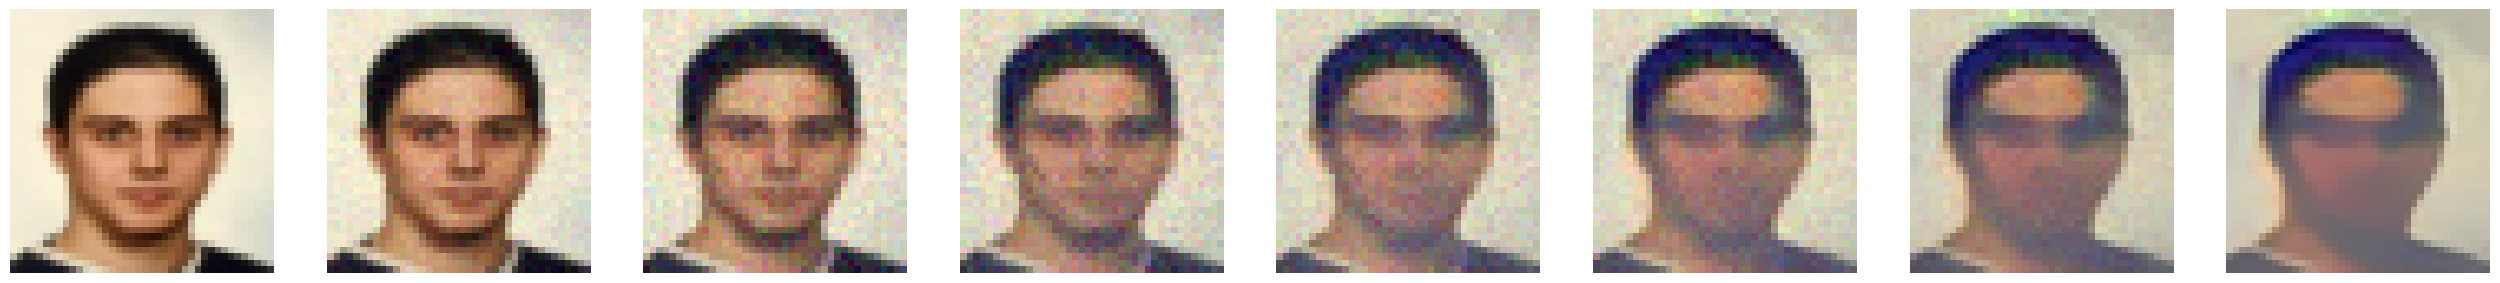

In [ ]:
x = torch.tensor(sample.detach().numpy()) #np.transpose(x,[2,0,1])
aux_x = x.float()

sample2, interm_Ys2 = univ_inv_sol_val(denoiser,
                                 x = aux_x-0.5,
                                 x_c = x_c,
                                 task = synth,
                                 sig_0 = 5,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = 0.5,  # change beta to see how quality of generated samples change
                                 freq = 5)

## plot the progression and the final sample
plot_synthesis(interm_Ys, sample)

# Inverse problems

In [ ]:
# Leer la imagen del ejemplo
if 0:
    if grayscale is True:
        path = 'test_images/grayscale/'
    else:
        path = 'test_images/color/'
    print('Test datasets: ', os.listdir(path))

    test_folder = 'Set14'

    # choose an image number
    im_num = 3
    X = test_image(grayscale, path+test_folder+'/', im_num)
    X.show()

    x = X.crop(210,250,60,60)
    x.dtype

In [ ]:
# LEER IMAGEN DE UN URL
from PIL import Image

import requests

url = "https://www.uv.es/lapeva/Valero_2001.jpg"
im = Image.open(requests.get(url, stream=True).raw)

XX = im.resize([60,60],2)

x = np.asarray(XX)/255
print(x.shape)

x = torch.tensor(x).permute(2,0,1) #np.transpose(x,[2,0,1])
x = x.float()
print(x.shape)

(60, 60, 3)
torch.Size([3, 60, 60])


1. Inpainting

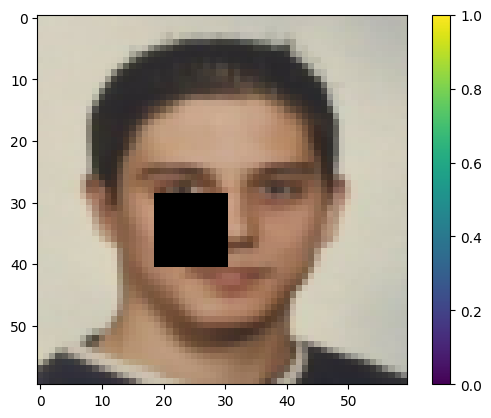

In [ ]:
# Specify top-left corner and size of "hole" to be inpainted (filled in) ***
#inpaint = inpainting(x_size=x.size(), y0=25, x0=35, h=20, w=20)

inpaint = inpainting(x_size=x.shape, y0=25, x0=35, h=12, w=12)
plot_corrupted_im(inpaint.M(inpaint.M_T(x)))

----------------------------- 40
sigma  0.9258013367652893
----------------------------- 80
sigma  0.7830075025558472
----------------------------- 120
sigma  0.6579169034957886
----------------------------- 160
sigma  0.5101263523101807
----------------------------- 200
sigma  0.3799864947795868
----------------------------- 240
sigma  0.2788691222667694
----------------------------- 280
sigma  0.18397672474384308
----------------------------- 320
sigma  0.12437689304351807
----------------------------- 360
sigma  0.08499722182750702
----------------------------- 400
sigma  0.0592091865837574
----------------------------- 440
sigma  0.03664856776595116
----------------------------- 480
sigma  0.022152883931994438
----------------------------- 520
sigma  0.012674042023718357
-------- total number of iterations,  534
-------- average time per iteration (s),  0.1416


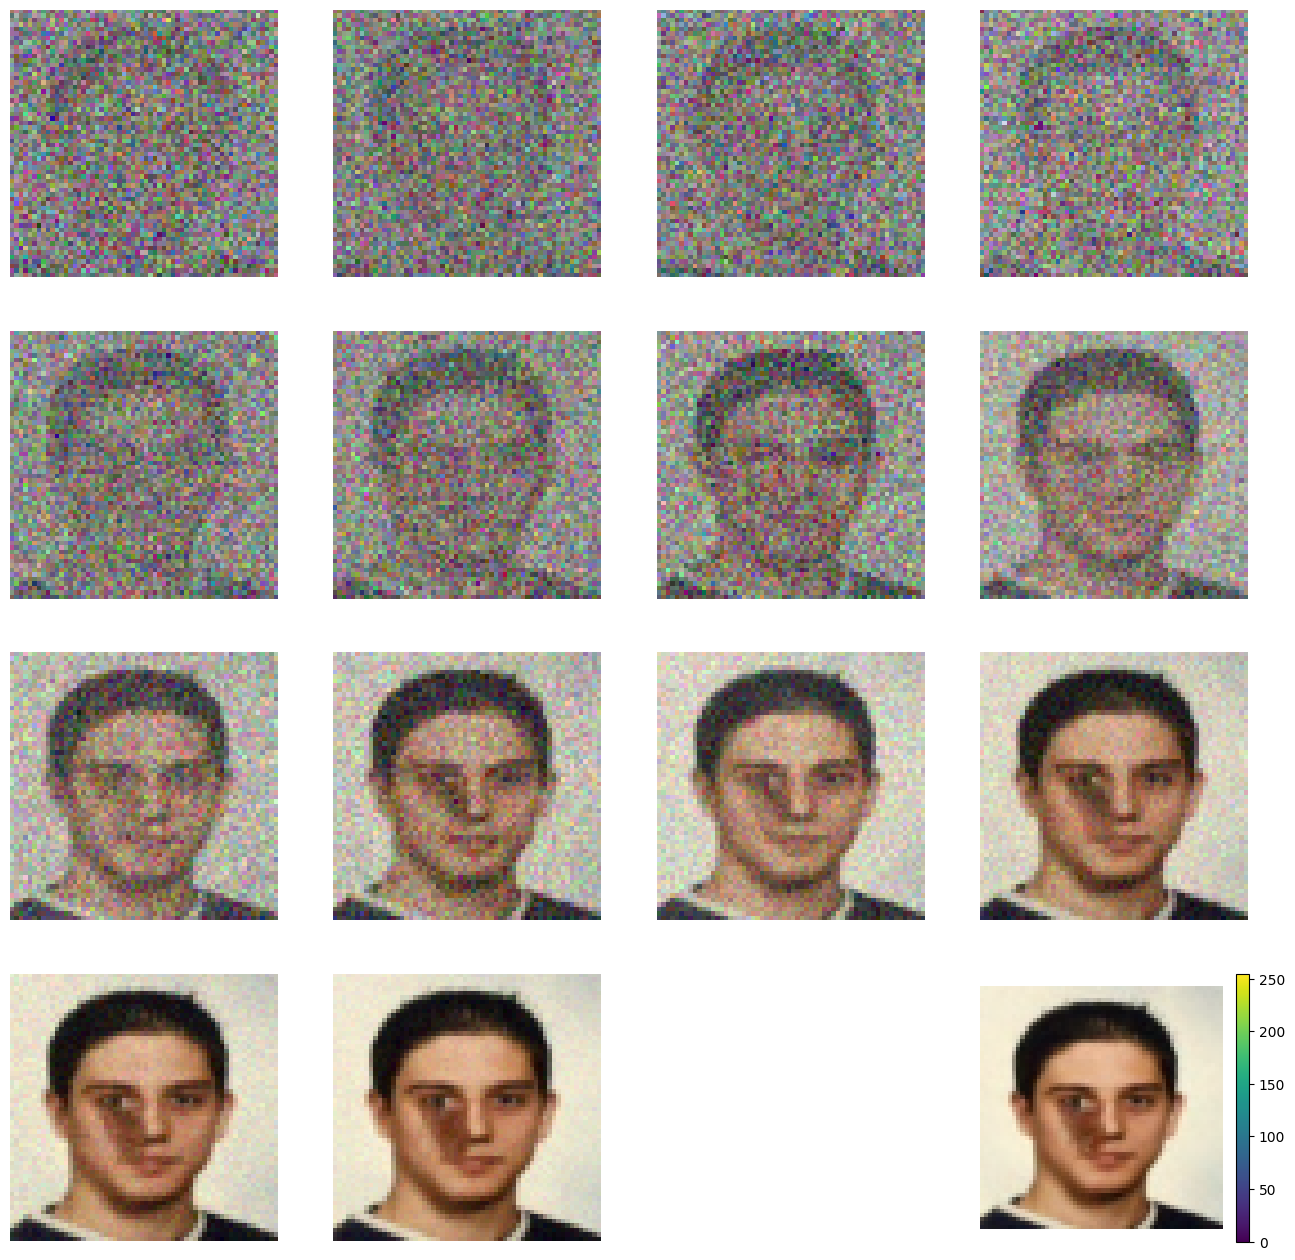

In [ ]:
# In solving linear inverse problems, in order to get good quality samples, beta should be small, that is lots of
# added noise in each iteration.
# This gives the algorithm the freedom to explore the space and arrive at a point on the manifold where the
# linear constraint is satisfied

sample, interm_Ys = univ_inv_sol(denoiser,
                                 x_c = inpaint.M_T(x),
                                 task = inpaint,
                                 sig_0 = 1,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = 0.01,
                                 freq = 40)
plot_all_samples(sample, interm_Ys)

/content/universal_inverse_problem/code/Utils_inverse_prob.py:203: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = np.round(structural_similarity(x.numpy(), corrupted.numpy(), multichannel=True  ) ,3 )
/content/universal_inverse_problem/code/Utils_inverse_prob.py:208: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = np.round(structural_similarity(x.numpy(), sample.numpy() , multichannel=True) ,3)


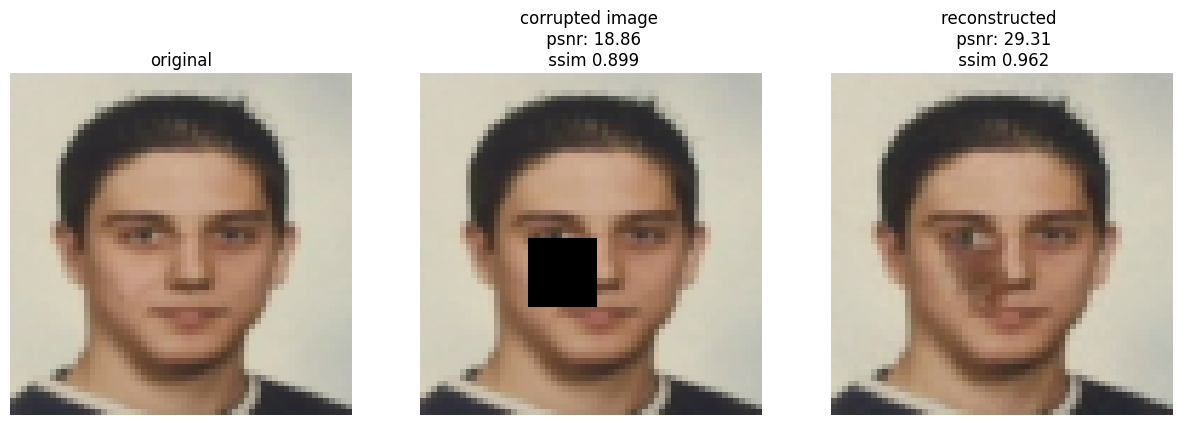

In [ ]:
plot_sample(x, inpaint.M(inpaint.M_T(x)), sample)

2. Missing random pixels

*** Retained 2160 / 10800 (20.0%) of dimensions
----------------------------- 40
sigma  0.9256964921951294
----------------------------- 80
sigma  0.7712701559066772
----------------------------- 120
sigma  0.45695769786834717
----------------------------- 160
sigma  0.2679128050804138
----------------------------- 200
sigma  0.12440251559019089
----------------------------- 240
sigma  0.020821252837777138
-------- total number of iterations,  247
-------- average time per iteration (s),  0.1418


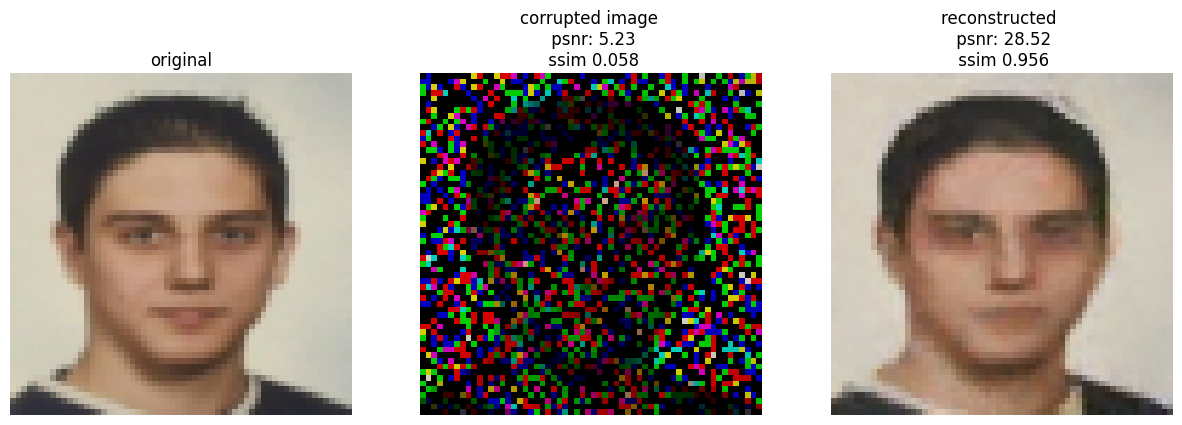

In [ ]:
# Retain a random subset of pixels.
rand_pix = rand_pixels(x_size = x.size(), p = 0.2) # p = fraction of pixels kept

print_dim(measurment_dim=rand_pix.mask.sum().item(), image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser,
                                 x_c = rand_pix.M_T(x),
                                 task = rand_pix,
                                 sig_0 = 1 ,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = 0.01,
                                 freq = 40)

plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

3. Super resolution

*** Retained 675 / 10800 (6.25%) of dimensions
----------------------------- 40
sigma  0.8653877377510071
----------------------------- 80
sigma  0.6676916480064392
----------------------------- 120
sigma  0.3990776538848877
----------------------------- 160
sigma  0.19847813248634338
----------------------------- 200
sigma  0.0636361688375473
-------- total number of iterations,  225
-------- average time per iteration (s),  0.1412


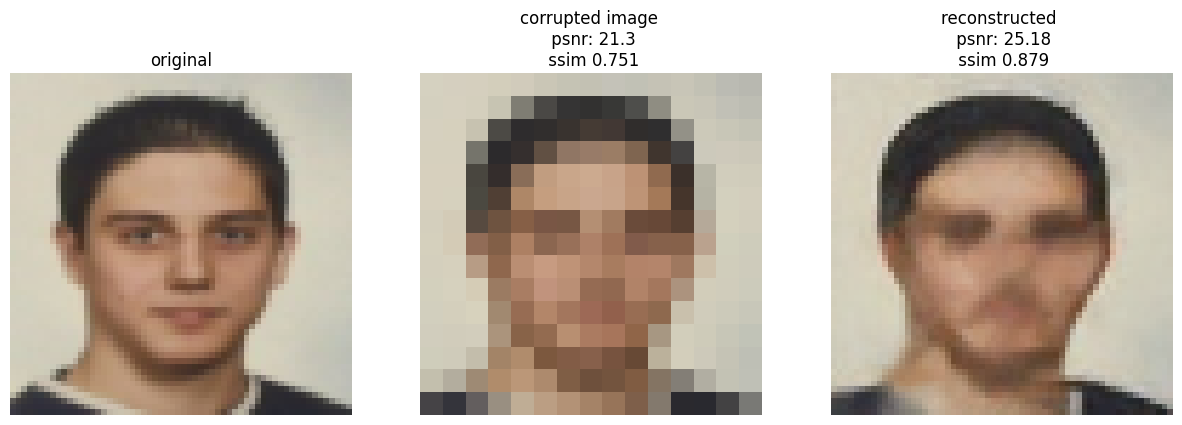

In [ ]:
# Subsample image by factor of s (both horizontally and vertially)
super_res = super_resolution(x_size=x.size(), s = 4)

print_dim(measurment_dim=np.prod(super_res.M_T(x).shape), image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser,
                                  x_c = super_res.M_T(x),
                                  task = super_res,
                                  sig_0 = 1 ,
                                  sig_L = 0.01,
                                  h0 = 0.01,
                                  beta = 0.01,
                                  freq = 40)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)

*** Retained 675 / 10800 (6.25%) of dimensions
----------------------------- 40
sigma  0.9436665177345276
----------------------------- 80
sigma  0.8205947279930115
----------------------------- 120
sigma  0.6711469888687134
----------------------------- 160
sigma  0.5287165641784668
----------------------------- 200
sigma  0.4034568667411804
----------------------------- 240
sigma  0.30077341198921204
----------------------------- 280
sigma  0.20970316231250763
----------------------------- 320
sigma  0.1382707953453064
----------------------------- 360
sigma  0.08884477615356445
----------------------------- 400
sigma  0.05456375330686569
----------------------------- 440
sigma  0.031216751784086227
----------------------------- 480
sigma  0.015157213434576988
-------- total number of iterations,  498
-------- average time per iteration (s),  2.0678


/content/universal_inverse_problem/code/Utils_inverse_prob.py:203: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = np.round(structural_similarity(x.numpy(), corrupted.numpy(), multichannel=True  ) ,3 )
/content/universal_inverse_problem/code/Utils_inverse_prob.py:208: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = np.round(structural_similarity(x.numpy(), sample.numpy() , multichannel=True) ,3)


ValueError: Input images must have the same dimensions.

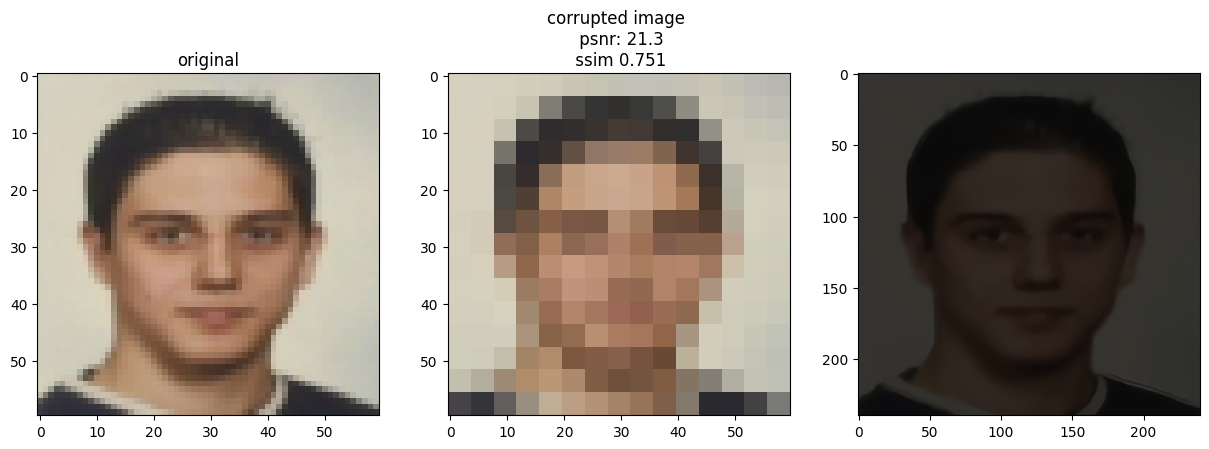

In [ ]:
# Subsample image by factor of s (both horizontally and vertially)
super_res = super_resolution(x_size=x.size(), s = 4)

print_dim(measurment_dim=np.prod(super_res.M_T(x).shape), image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser,
                                  x_c = x,#super_res.M_T(x),
                                  task = super_res,
                                  sig_0 = 1 ,
                                  sig_L = 0.01,
                                  h0 = 0.01,
                                  beta = 0.01,
                                  freq = 40)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)

4. Random basis

/content/universal_inverse_problem/code/Utils_inverse_prob.py:375: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2426.)
  self.U, _ = torch.qr(torch.randn(int(np.prod(x_size)),int(np.prod(x_size)*p) ))


*** Retained 2160 / 10800 (20.0%) of dimensions
----------------------------- 40
sigma  0.8928686380386353
----------------------------- 80
sigma  0.6417750716209412
----------------------------- 120
sigma  0.4481741786003113
----------------------------- 160
sigma  0.23747943341732025
----------------------------- 200
sigma  0.10047249495983124
----------------------------- 240
sigma  0.009206392802298069
-------- total number of iterations,  241
-------- average time per iteration (s),  0.1682


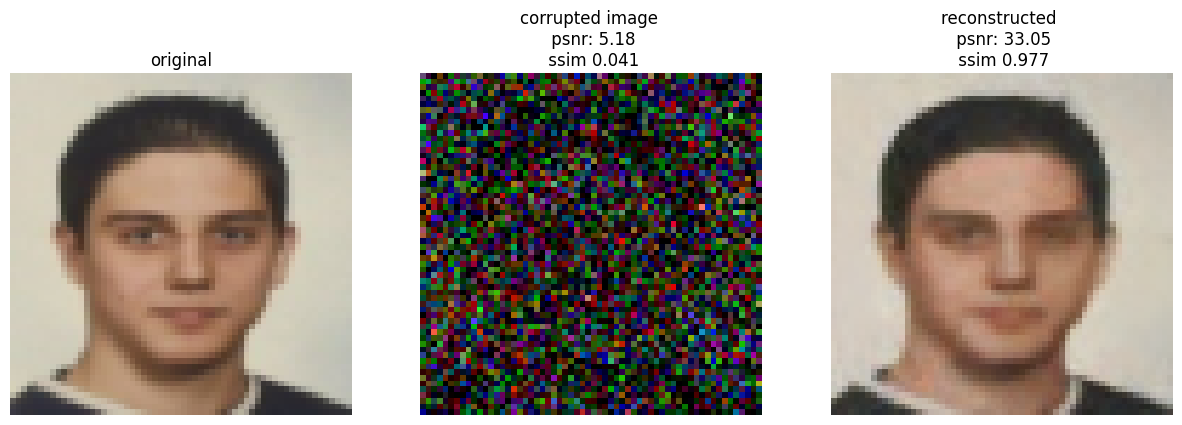

In [ ]:
# Project image onto a random set of basis functions
rand_basis = random_basis(x_size = x.shape , p = 0.2) # p = fraction of dimensions kept

print_dim(measurment_dim=rand_basis.U.shape[1], image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser,
                                 x_c = rand_basis.M_T(x),
                                 task = rand_basis,
                                 sig_0 = 1,
                                 sig_L = 0.01,
                                 h0 = 0.01,
                                 beta = .01,
                                 freq = 40)

plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)

5. Spectral super resolution

*** Retained 2028 / 10800 (18.778%) of dimensions
----------------------------- 40
sigma  0.9017474055290222
----------------------------- 80
sigma  0.7429386973381042
----------------------------- 120
sigma  0.5474101901054382
----------------------------- 160
sigma  0.37894606590270996
----------------------------- 200
sigma  0.24925342202186584
----------------------------- 240
sigma  0.12952393293380737
----------------------------- 280
sigma  0.04538966342806816
-------- total number of iterations,  301
-------- average time per iteration (s),  0.127


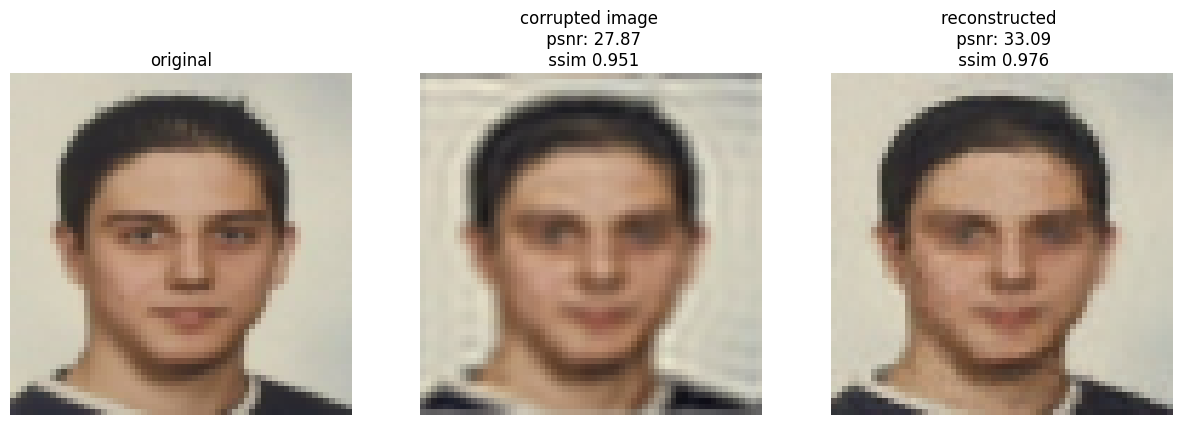

In [ ]:
# Project onto low frequencies (a subset of the Fourier basis)
spec_super_res = spectral_super_resolution(x_size= x.size(), p = 0.2) # p=fraction of low frequencies kept

print_dim(measurment_dim=spec_super_res.mask.sum()*C, image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser,
                                  x_c=spec_super_res.M_T(x),
                                  task = spec_super_res,
                                  sig_0=1 ,
                                  sig_L=.01,
                                  h0=.01,
                                  beta = 0.01,
                                  freq = 40)

plot_sample(x, spec_super_res.M(spec_super_res.M_T(x) ), sample)